In [1]:
# import das bibliotecas que serão usadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# import dos modelos que serão usados

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor


## Leitura dos dados

In [2]:
# Leitura dos dados do PIB

pib = pd.read_csv('PIB_mensal.csv')


# Leitura dos dados gerais de movimentação dos conteiners 

df = pd.read_csv('df_final.csv')
df.drop(columns =['Unnamed: 0'],inplace = True)

## Tratamento das Tabelas

In [3]:
# Tratamento das colunas da Tabela do PIB

pib['PIB'] = pib['PIB'].str.replace('.','')
pib['PIB'] = pib['PIB'].str.replace(',','.')
pib['PIB'] = pib['PIB'].astype(float)
pib['PIB growth'] = pib['PIB growth'].str.replace(',','.')
pib['PIB growth'] = pib['PIB growth'].str.replace('%','')
pib['PIB growth'] = pib['PIB growth'].astype(float)


# Tratamento das colunas da tabela geral

df['Mes']=df['Mes'].map({'jan':'01','fev':'02','mar':'03','abr':'04',
             'mai':'05','jun':'06','jul':'07','ago':'08',
             'set':'09','out':'10','nov':'11','dez':'12'})



/tmp/ipykernel_38462/1935979781.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pib['PIB'] = pib['PIB'].str.replace('.','')


In [4]:
# Criação de uma coluna de data para ser usada como base para criação de novas variáveis de tempo

df['Mes'] = df['Mes'].astype(str)
df['Ano'] = df['Ano'].astype(str)
df['Dia'] = df['Dia'].astype(str)
df['Data'] = df['Ano'] + '-' + df['Mes'] + '-' + df['Dia']
df['Data'] = pd.to_datetime(df['Data'])
df['Mes'] = df['Mes'].astype(int)
df['Ano'] = df['Ano'].astype(int)
df['Dia'] = df['Dia'].astype(int)


# Criação de novas colunas relacionadas ao tempo

df['dayofyear'] = df['Data'].apply(lambda x: x.dayofyear)
df['weekofyear'] = df['Data'].apply(lambda x: x.weekofyear)
df['week_day'] = df['Data'].dt.dayofweek
# df['year'] = df['Data'].dt.year
# df['month'] = df['Data'].dt.month
# df['day'] = df['Data'].dt.day
# df['month_initial'] = df['Data'].dt.is_month_start
# df['month_end'] = df['Data'].dt.is_month_end
# df['start_quarter'] = df['Data'].dt.is_quarter_start



In [5]:
# Junção da tabela geral e da tabela do PIB

df = df.merge(pib, how='left', on=['Ano','Mes'])
df = df.sort_values(by=['Ano','Mes','Dia'])

In [6]:
# Separação das features diarias

var_def_diaria = pd.DataFrame(df[['Cotacao_Dol','Data']])



# Agregação da feature no dia e tirando a média

var_def_diaria = var_def_diaria.groupby(by=['Data']).mean().reset_index()




# Transformando a feature para a media dos 30 ultimos dias 

var_def_diaria_1 = var_def_diaria.rolling(30, min_periods=30, on = 'Data').mean().round(2)



In [7]:
# Separação das features mensais

var_def_mensal = pd.DataFrame(df[['Chave_Total retail trade (Volume) sa, IndexBrazil','PIB', 'PIB growth','Mes','Ano']])


# Agregação da feature no dia e tirando a média

var_def_mensal = var_def_mensal.groupby(by=['Ano','Mes']).mean().reset_index()
datas_mes = var_def_mensal[['Ano','Mes']]
var_def_mensal = var_def_mensal.drop(columns = ['Ano','Mes'])


# Transformando a feature para a media dos 2 ultimos meses 

var_def_mensal_1 = var_def_mensal.rolling(2, min_periods=2).mean().round(2)


var_def_mensal_1['Ano'] = datas_mes['Ano']
var_def_mensal_1['Mes'] = datas_mes['Mes']

In [8]:
# Criação do DataFrame com as features que sofreram defasagem de tempo

df_novo = df[['ConteinerEstado','Tipo Navegação','FlagConteinerTamanho','Sentido','TEU','Dia','Mes','Ano','Taxa_desocupacao'
             ,'Mes_freq_encode','Data','dayofyear','weekofyear','week_day']]



# Junção do novo DataFrame com as tabelas diárias e mensais

df_novo = df_novo.merge(var_def_diaria_1,how = 'left',on = 'Data')
df_novo = df_novo.merge(var_def_mensal_1,how = 'left',on = ['Mes','Ano'])

In [9]:
# Criação de DataFrames separadados para containers de 20 TEUS e 40 TEUS

df_40 = df_novo[df['FlagConteinerTamanho'] == 40]
df_20 = df_novo[df['FlagConteinerTamanho'] == 20]

/tmp/ipykernel_38462/1902605818.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_40 = df_novo[df['FlagConteinerTamanho'] == 40]
/tmp/ipykernel_38462/1902605818.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_20 = df_novo[df['FlagConteinerTamanho'] == 20]


In [10]:
# Função para descobrir quantos dados são OUTLIERS

def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result


def outliers_count_Percentile(df, col):
    try:
        if len(df[col].unique())>2:
            q1 = df[col].quantile(0.025)
            q3 = df[col].quantile(0.975)
           # iqr_range = q3 - q1
           # lower = q1 - 1.5*iqr_range
           # lower = q3 + 1.5*iqr_range 
            lower = q1 
            upper = q3 
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc

def EDA_morestats(df):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    colunas = df.columns.tolist()
    
        
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), colunas), index=colunas)
    eda_df['Mean'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_Percentile(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_Percentile(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

In [11]:
EDA_morestats(df_novo[['TEU']])

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Min,Max,STD,Normality,Amount_Outliers,%_Outliers
TEU,0,0.0,int64,943315,715,5.388,1,2018,27.562,not_applicable,23043,0.02


In [12]:
# Função para saber o erromédio entre o previsto e o real
def med(y_true, y_pred): 
    y_true += 1e-5
    return np.median(np.abs(y_true - y_pred) / y_true)

In [13]:
# Função para detectar quais dados são OUTLIERS

def low_upper_limit (df):
    out_values = []
    q1 = df['TEU'].quantile(0.05)
    q3 = df['TEU'].quantile(0.95)
#    iqr_range = q3 - q1
    lower = q1
    upper = q3
    for i in df['TEU']:
        if i < lower or i > upper:
            out_values.append(i)
    return out_values,lower,upper


# Salvando em parametros quais são os limites dos OUTLIER

out_values_20,lower_20,upper_20 = low_upper_limit(df_20)
out_values_40,lower_40,upper_40 = low_upper_limit(df_40)
out_values,lower,upper = low_upper_limit(df_novo)

In [14]:
# # Faendo a troca dos valores OUTLIER por NAN e aplicando o drop desses valores nulos
# # E criação de novos DataFrames para os os dois tipos de containers separados e para eles juntos

# for i in out_values_20:
#     df_20['TEU'].replace(i,np.nan,inplace=True)
# df2_20 = df_20.dropna()
# print('Dataframe de 20 TEUS finalizado')


# for i in out_values_40:
#     df_40['TEU'].replace(i,np.nan,inplace=True)
# df2_40 = df_40.dropna()
# print('Dataframe de 40 TEUS finalizado')


# for i in out_values:
#     df_novo['TEU'].replace(i,np.nan,inplace=True)
# df2 = df_novo.dropna()
# print('Dataframe de 20 e 40 TEUS juntos finalizado')

# Regressão Linear para o Dataframe de 20 e 40 TEUS juntos

In [15]:
df3 = df_novo
df_final_pre = df3.copy()

In [16]:
# Normalização do Dataframe para que se tenha apenas uma linha por cada data

df_final_1 = df_final_pre[['TEU','Data','FlagConteinerTamanho']]
df_final_2 = df_final_pre[['ConteinerEstado', 'Tipo Navegação', 'Sentido' ,'Dia', 'Ano', 'Mes',
       'Chave_Total retail trade (Volume) sa, IndexBrazil', 'Taxa_desocupacao',
       'Cotacao_Dol', 'Data', 'dayofyear', 'weekofyear','week_day','FlagConteinerTamanho','PIB','PIB growth']]

df_final_1 = df_final_1.groupby(by=['Data','FlagConteinerTamanho']).sum().reset_index()
df_final_2 = df_final_2.groupby(by=['Data','FlagConteinerTamanho']).mean().reset_index()

df_final = df_final_1.merge(df_final_2, how='inner', on=['Data','FlagConteinerTamanho'])

In [17]:
# Faendo a troca dos valores OUTLIER por NAN e aplicando o drop desses valores nulos
# E criação de novos DataFrames para os os dois tipos de containers separados e para eles juntos

for i in out_values:
    df_final['TEU'].replace(i,np.nan,inplace=True)
df_final = df_final.dropna()
print('Dataframe de 20 e 40 TEUS juntos finalizado')

Dataframe de 20 e 40 TEUS juntos finalizado


In [18]:
# Criação do CSV que será usado no notebook de regressão agregado por mês

# df_final.to_csv('base_final_correta.csv')

In [19]:
# Separação em DataFrames de teste e treino que serão usados no modelo

treino = df_final.loc[(df_final['Data'] >= '2015-01-01') & (df_final['Data'] <= '2017-12-31')]


y_treino = treino['TEU'].values
del treino['TEU']
# del treino['Ano']
del treino['Data']
x_treino = treino.values

#-----------------------------------------

teste = df_final.loc[(df_final['Data'] >= '2018-01-01') & (df_final['Data'] <= '2018-12-31')]


y_teste = teste['TEU'].values
del teste['TEU']
# del teste['Ano']
del teste['Data']

x_teste = teste.values


#-----------------------------------------

del df_final['TEU']
# del df_final['Ano']
del df_final['Data']

x_teste_df = pd.DataFrame(x_teste, columns = df_final.columns.tolist())
x_treino_df = pd.DataFrame(x_treino, columns = df_final.columns.tolist())

In [20]:
# Normalização dos dados de treino e teste utilizando o standard scaler


scaler = preprocessing.StandardScaler().fit(x_treino_df.values)

x_train_norm = scaler.transform(x_treino_df.values)
x_test_norm = scaler.transform(x_teste_df.values)

In [21]:
# Aplicação do modelo e vizualiação das métricas


reg = LinearRegression().fit(x_train_norm, y_treino)
y_pred = reg.predict(x_test_norm)


print('Total')
print('r_2_treino: ',reg.score(x_train_norm, y_treino))
print('r_2_teste: ',reg.score(x_test_norm, y_teste))
print('mean_square_erro: ',(mean_squared_error(y_teste, y_pred))**0.5)
print('média erro: ',med(y_teste,y_pred))

Total
r_2_treino:  0.4540953263528036
r_2_teste:  0.10513170957042683
mean_square_erro:  2977.841283833054
média erro:  0.3644716322293713


TOTAL


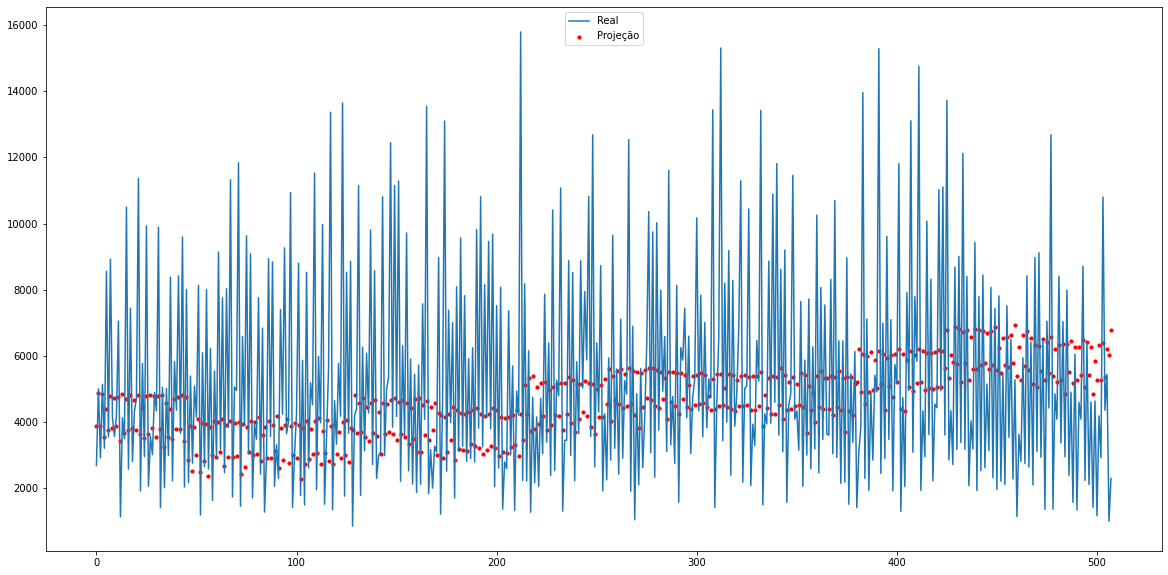

In [22]:
# Print dos resultados previstos em relação aos resultados reais


print('TOTAL')

min_index = 0
max_index = 560

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df.index[min_index:max_index], y_teste[min_index:max_index], label='Real')
ax1.scatter(x_teste_df.index[min_index:max_index], y_pred[min_index:max_index], s=10, c='r', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [23]:
# Tabela de importância das features para o modelo

print('TOTAL')
importance_df = pd.DataFrame()
importance_df['colunas'] = treino.columns.tolist()
importance_df['importancia'] = list(reg.coef_)
importance_df['importancia_abs'] = np.abs(list(reg.coef_))

importance_df = importance_df.sort_values(by='importancia_abs', ascending=False)
del importance_df['importancia_abs']

importance_df

TOTAL


,colunas,importancia
10,dayofyear,18671.088316
6,Mes,-18084.335670
5,Ano,1796.580486
8,Taxa_desocupacao,-1613.330490
4,Dia,-1583.254979
0,FlagConteinerTamanho,504.882780
14,PIB growth,316.215195
1,ConteinerEstado,185.053636
11,weekofyear,-158.537664
7,"Chave_Total retail trade (Volume) sa, IndexBrazil",-133.482353


In [24]:
# Tabela com os dados reais, previstos e as diferenças entre eles

analise = pd.DataFrame(y_pred,columns = ['y_pred'])
analise['y_real'] = y_teste
analise['dif_abs'] = ((analise['y_pred'] - analise['y_real'])**2)**(1/2)
analise['dif_perc'] = 100*((analise['y_pred'] - analise['y_real'])**2)**(1/2)/(analise['y_real'])
analise.head()

,y_pred,y_real,dif_abs,dif_perc
0,3886.756681,2677.00001,1209.756671,45.190761
1,4860.966579,4998.00001,137.033431,2.741765
2,3874.664353,2907.00001,967.664343,33.287387
3,4838.675466,5134.00001,295.324544,5.752328
4,3534.595392,3199.00001,335.595382,10.490634


# Regressão Linear para o Dataframe de 20 TEUS

In [25]:
df3_20 = df_20.drop(columns= ['FlagConteinerTamanho'])
df_final_pre_20 = df3_20.copy()

In [26]:
# Normalização do Dataframe para que se tenha apenas uma linha por cada data

df_final_1_20 = df_final_pre_20[['TEU','Data']]
df_final_2_20 = df_final_pre_20[['ConteinerEstado', 'Tipo Navegação', 'Sentido' ,'Dia', 'Ano', 'Mes',
       'Chave_Total retail trade (Volume) sa, IndexBrazil', 'Taxa_desocupacao',
       'Cotacao_Dol', 'Data', 'dayofyear', 'weekofyear','week_day','PIB','PIB growth']]

df_final_1_20 = df_final_1_20.groupby(by=['Data']).sum().reset_index()
df_final_2_20 = df_final_2_20.groupby(by=['Data']).mean().reset_index()

df_final_20 = df_final_1_20.merge(df_final_2_20, how='inner', on=['Data'])

In [27]:
# Faendo a troca dos valores OUTLIER por NAN e aplicando o drop desses valores nulos
# E criação de novos DataFrames para os os dois tipos de containers separados e para eles juntos

for i in out_values_20:
    df_final_20['TEU'].replace(i,np.nan,inplace=True)
df_final_20 = df_final_20.dropna()
print('Dataframe de 20 TEUS finalizado')

Dataframe de 20 TEUS finalizado


In [28]:
# Criação do CSV que será usado no notebook de regressão agregado por mês

# df_final_20.to_csv('base_final_correta_20.csv')

In [29]:
# Separação em DataFrames de teste e treino que serão usados no modelo

treino_20 = df_final_20.loc[(df_final_20['Data'] >= '2015-01-01') & (df_final_20['Data'] <= '2017-12-31')]

y_treino_20 = treino_20['TEU'].values
del treino_20['TEU']
# del treino['Ano']
del treino_20['Data']
x_treino_20 = treino_20.values

#-----------------------------------------

teste_20 = df_final_20.loc[(df_final_20['Data'] >= '2018-01-01') & (df_final_20['Data'] <= '2018-12-31')]


y_teste_20 = teste_20['TEU'].values
del teste_20['TEU']
# del teste['Ano']
del teste_20['Data']

x_teste_20 = teste_20.values


#-----------------------------------------


del df_final_20['TEU']
# del df_final['Ano']
del df_final_20['Data']

x_teste_df_20 = pd.DataFrame(x_teste_20, columns = df_final_20.columns.tolist())
x_treino_df_20 = pd.DataFrame(x_treino_20, columns = df_final_20.columns.tolist())

In [30]:
# Normalização dos dados de treino e teste utilizando o standard scaler

scaler_20 = preprocessing.StandardScaler().fit(x_treino_df_20.values)

x_train_norm_20 = scaler_20.transform(x_treino_df_20.values)
x_test_norm_20 = scaler_20.transform(x_teste_df_20.values)


In [31]:
# Aplicação do modelo e vizualiação das métricas

reg_20 = LinearRegression().fit(x_train_norm_20, y_treino_20)
y_pred_20 = reg_20.predict(x_test_norm_20)
print('20 TEU')
print('r_2_treino: ', reg_20.score(x_train_norm_20, y_treino_20))
print('r_2_teste: ', reg_20.score(x_test_norm_20, y_teste_20))
print('mean_square_erro: ',(mean_squared_error(y_teste_20, y_pred_20))**0.5)
print('média erro: ',med(y_teste_20,y_pred_20))

20 TEU
r_2_treino:  0.34738232711214745
r_2_teste:  -0.24502341944486328
mean_square_erro:  3053.3680163323543
média erro:  0.4625210864162964


20 TEUS


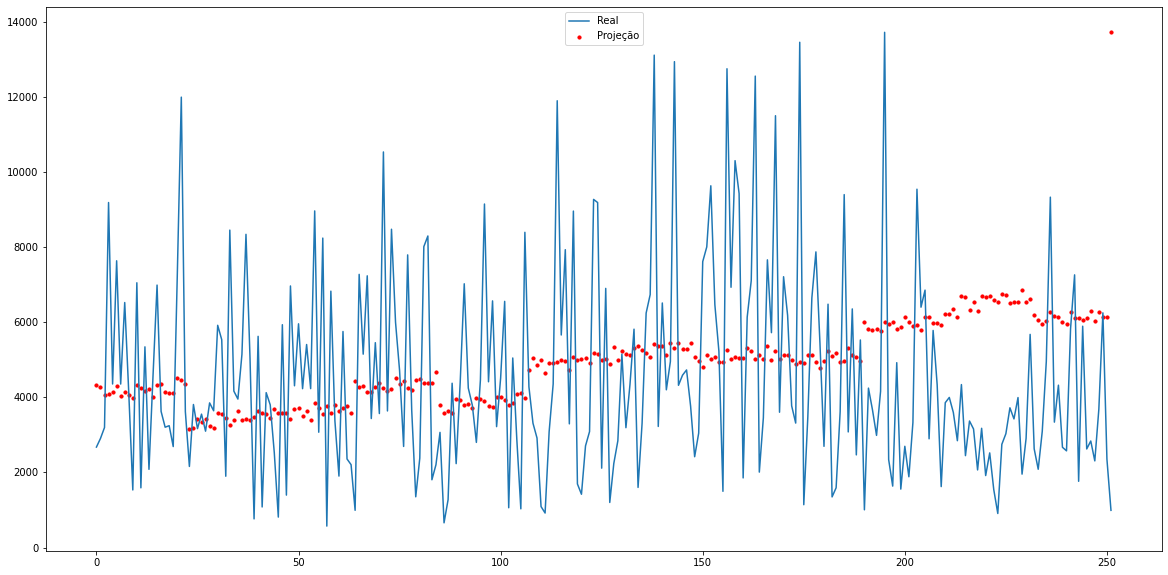

In [32]:
# Print dos resultados previstos em relação aos resultados reais


print('20 TEUS')
min_index = 0
max_index = 560

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df_20.index[min_index:max_index], y_teste_20[min_index:max_index], label='Real')
ax1.scatter(x_teste_df_20.index[min_index:max_index], y_pred_20[min_index:max_index], s=10, c='r', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [33]:
# Tabela de importância das features para o modelo


print('20 TEUS')
importance_df_20 = pd.DataFrame()
importance_df_20['colunas'] = treino_20.columns.tolist()
importance_df_20['importancia'] = list(reg_20.coef_)
importance_df_20['importancia_abs'] = np.abs(list(reg_20.coef_))

importance_df_20 = importance_df_20.sort_values(by='importancia_abs', ascending=False)
del importance_df_20['importancia_abs']

importance_df_20

20 TEUS


,colunas,importancia
9,dayofyear,21633.741354
5,Mes,-18982.862611
10,weekofyear,-2088.956813
4,Ano,2001.814258
7,Taxa_desocupacao,-1708.528517
3,Dia,-1626.953157
13,PIB growth,410.250158
12,PIB,-179.876326
6,"Chave_Total retail trade (Volume) sa, IndexBrazil",-154.799724
11,week_day,-114.194607


In [34]:
# Tabela com os dados reais, previstos e as diferenças entre eles


analise_20 = pd.DataFrame(y_pred_20,columns = ['y_pred'])
analise_20['y_real'] = y_teste_20
analise_20['dif_abs'] = ((analise_20['y_pred'] - analise_20['y_real'])**2)**(1/2)
analise_20['dif_perc'] = 100*((analise_20['y_pred'] - analise_20['y_real'])**2)**(1/2)/(analise_20['y_real'])
analise_20.head()

,y_pred,y_real,dif_abs,dif_perc
0,4334.938199,2677.00001,1657.938189,61.932693
1,4277.361711,2907.00001,1370.361701,47.140065
2,4075.147840,3199.00001,876.147830,27.388178
3,4083.278678,9196.00001,5112.721332,55.597231
4,4135.463294,4359.00001,223.536716,5.128165


# Regressão Linear para o Dataframe de 40 TEUS

In [35]:
df3_40 = df_40.drop(columns= ['FlagConteinerTamanho'])
df_final_pre_40 = df3_40.copy()

In [36]:
# Normalização do Dataframe para que se tenha apenas uma linha por cada data


df_final_1_40 = df_final_pre_40[['TEU','Data']]
df_final_2_40 = df_final_pre_40[['ConteinerEstado', 'Tipo Navegação', 'Sentido' ,'Dia', 'Ano', 'Mes',
       'Chave_Total retail trade (Volume) sa, IndexBrazil', 'Taxa_desocupacao',
       'Cotacao_Dol', 'Data', 'dayofyear', 'weekofyear','week_day','PIB','PIB growth']]

df_final_1_40= df_final_1_40.groupby(by=['Data']).sum().reset_index()
df_final_2_40 = df_final_2_40.groupby(by=['Data']).mean().reset_index()

df_final_40 = df_final_1_40.merge(df_final_2_40, how='inner', on=['Data'])

In [37]:
# Faendo a troca dos valores OUTLIER por NAN e aplicando o drop desses valores nulos
# E criação de novos DataFrames para os os dois tipos de containers separados e para eles juntos

for i in out_values_40:
    df_final_40['TEU'].replace(i,np.nan,inplace=True)
df_final_40 = df_final_40.dropna()
print('Dataframe de 20 TEUS finalizado')

Dataframe de 20 TEUS finalizado


In [38]:
# Criação do CSV que será usado no notebook de regressão agregado por mês

# df_final_40.to_csv('base_final_correta_40.csv')

In [39]:
# Separação em DataFrames de teste e treino que serão usados no modelo

treino_40 = df_final_40.loc[(df_final_40['Data'] >= '2015-01-01') & (df_final_40['Data'] <= '2017-12-31')]


y_treino_40 = treino_40['TEU'].values
del treino_40['TEU']
# del treino['Ano']
del treino_40['Data']
x_treino_40 = treino_40.values

#-----------------------------------------

teste_40 = df_final_40.loc[(df_final_40['Data'] >= '2018-01-01') & (df_final_40['Data'] <= '2018-12-31')]


y_teste_40 = teste_40['TEU'].values
del teste_40['TEU']
# del teste['Ano']
del teste_40['Data']

x_teste_40 = teste_40.values

#-----------------------------------------

del df_final_40['TEU']
# del df_final['Ano']
del df_final_40['Data']

x_teste_df_40 = pd.DataFrame(x_teste_40, columns = df_final_40.columns.tolist())
x_treino_df_40 = pd.DataFrame(x_treino_40, columns = df_final_40.columns.tolist())

In [40]:
# Normalização dos dados de treino e teste utilizando o standard scaler

scaler_40 = preprocessing.StandardScaler().fit(x_treino_df_40.values)

x_train_norm_40 = scaler_40.transform(x_treino_df_40.values)
x_test_norm_40 = scaler_40.transform(x_teste_df_40.values)

In [41]:
# Aplicação do modelo e vizualiação das métricas

reg_40 = LinearRegression().fit(x_train_norm_40, y_treino_40)
y_pred_40 = reg_40.predict(x_test_norm_40)
print('40 TEU')
print('r_2_treino: ', reg_40.score(x_train_norm_40, y_treino_40))
print('r_2_teste :', reg_40.score(x_test_norm_40, y_teste_40))
print('mean_square_erro: ',(mean_squared_error(y_teste_40, y_pred_40))**0.5)
print('média erro: ',med(y_teste_40,y_pred_40))

40 TEU
r_2_treino:  0.23009681845235708
r_2_teste : -0.3969686687330356
mean_square_erro:  3495.510591238488
média erro:  0.38199132238809363


40 TEUS


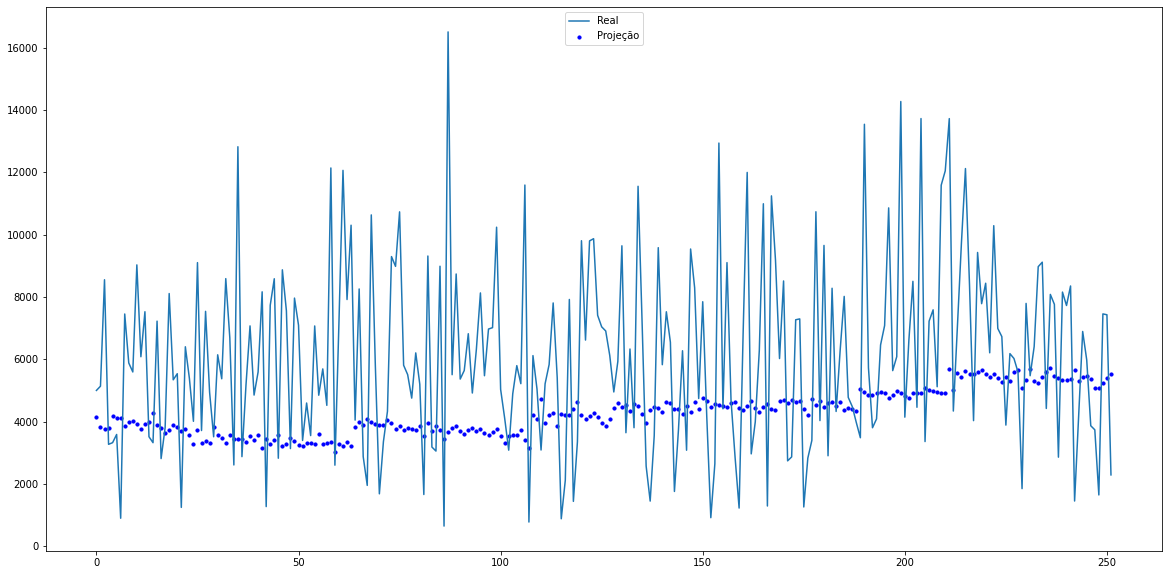

In [42]:
# Print dos resultados previstos em relação aos resultados reais

print('40 TEUS')
min_index = 0
max_index = 560

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df_40.index[min_index:max_index], y_teste_40[min_index:max_index], label='Real')
ax1.scatter(x_teste_df_40.index[min_index:max_index], y_pred_40[min_index:max_index], s=10, c='b', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [43]:
# Tabela de importância das features para o modelo

print('20 TEUS')
importance_df_40 = pd.DataFrame()
importance_df_40['colunas'] = treino_40.columns.tolist()
importance_df_40['importancia'] = list(reg_40.coef_)
importance_df_40['importancia_abs'] = np.abs(list(reg_20.coef_))

importance_df_40 = importance_df_40.sort_values(by='importancia_abs', ascending=False)
del importance_df_40['importancia_abs']

importance_df_40

20 TEUS


,colunas,importancia
9,dayofyear,16949.275846
5,Mes,-16387.877483
10,weekofyear,-172.348682
4,Ano,1337.066144
7,Taxa_desocupacao,-1144.112316
3,Dia,-1489.080446
13,PIB growth,180.174636
12,PIB,76.282057
6,"Chave_Total retail trade (Volume) sa, IndexBrazil",55.681473
11,week_day,-21.435681


In [44]:
# Tabela com os dados reais, previstos e as diferenças entre eles

analise_40 = pd.DataFrame(y_pred_40,columns = ['y_pred'])
analise_40['y_real'] = y_teste_40
analise_40['dif_abs'] = ((analise_40['y_pred'] - analise_40['y_real'])**2)**(1/2)
analise_40['dif_perc'] = 100*((analise_40['y_pred'] - analise_40['y_real'])**2)**(1/2)/(analise_40['y_real'])
analise_40.head()

,y_pred,y_real,dif_abs,dif_perc
0,4133.272857,4998.00001,864.727153,17.301464
1,3821.012183,5134.00001,1312.987827,25.574364
2,3759.705485,8552.00001,4792.294525,56.037120
3,3794.977607,3267.00001,527.977597,16.160930
4,4183.016896,3321.00001,862.016886,25.956546


# Árvore de decisão para o Dataframe de 20 e 40 TEUS juntos

In [45]:
# Aplicação do modelo e vizualiação das métricas


print ('Decision Tree')

clf = DecisionTreeRegressor()
clf.fit(x_treino_df, y_treino)
pred = clf.predict(x_teste_df)
score_teste = clf.score(x_teste_df, y_teste)
score_treino = clf.score(x_treino_df, y_treino)
print('TOTAL')
print("R-squared_treino:", score_treino) 
print("R-squared_teste:", score_teste) 
mse = mean_squared_error(y_teste, pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 
print('Média de erro: ',med(y_teste,pred))

Decision Tree
TOTAL
R-squared_treino: 1.0
R-squared_teste: -0.10525927860203588
MSE:  10952370.91792008
RMSE:  3309.43664660922
Média de erro:  0.4165937179947556


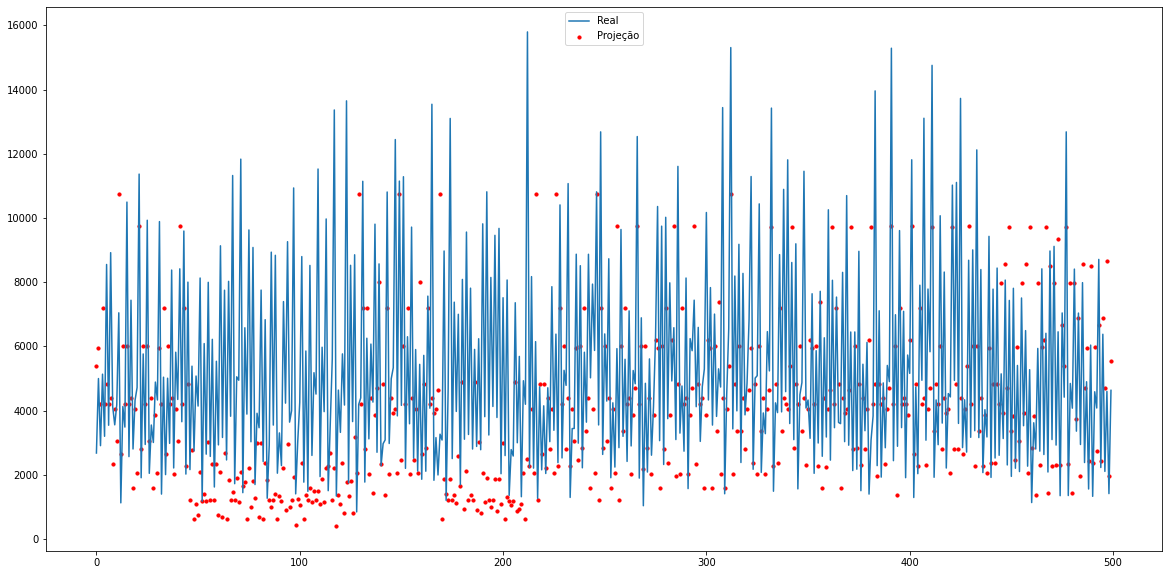

In [46]:
# Print dos resultados previstos em relação aos resultados reais


min_index = 0
max_index = 500

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df.index[min_index:max_index], y_teste[min_index:max_index], label='Real')
ax1.scatter(x_teste_df.index[min_index:max_index], pred[min_index:max_index], s=10, c='r', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [47]:
# Tabela com os dados reais, previstos e as diferenças entre eles


analise_arv = pd.DataFrame(pred,columns = ['y_pred'])
analise_arv['y_real'] = y_teste
analise_arv['dif_abs'] = ((analise_arv['y_pred'] - analise_arv['y_real'])**2)**(1/2)
analise_arv['dif_perc'] = 100*((analise_arv['y_pred'] - analise_arv['y_real'])**2)**(1/2)/(analise_arv['y_real'])
analise_arv.head()

,y_pred,y_real,dif_abs,dif_perc
0,5385.0,2677.00002,2707.99998,101.158011
1,5954.0,4998.00002,955.99998,19.127651
2,4220.0,2907.00002,1312.99998,45.166838
3,7208.0,5134.00002,2073.99998,40.397350
4,4220.0,3199.00002,1020.99998,31.916223


# Árvore de decisão para o Dataframe de 20 TEUS

In [48]:
# Aplicação do modelo e vizualiação das métricas

print ('Decision Tree')

clf_20 = DecisionTreeRegressor()
clf_20.fit(x_treino_df_20, y_treino_20)
pred_20 = clf_20.predict(x_teste_df_20)
score_teste_20 = clf_20.score(x_teste_df_20, y_teste_20)
score_treino_20= clf_20.score(x_treino_df_20, y_treino_20)
print('20 TEU')
print("R-squared_treino:", score_treino_20) 
print("R-squared_teste:", score_teste_20) 
mse = mean_squared_error(y_teste_20, pred_20)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 
print('Média de erro: ',med(y_teste_20,pred_20))

Decision Tree
20 TEU
R-squared_treino: 1.0
R-squared_teste: -1.121170344084895
MSE:  15883870.223137777
RMSE:  3985.4573417787046
Média de erro:  0.6253925509478403


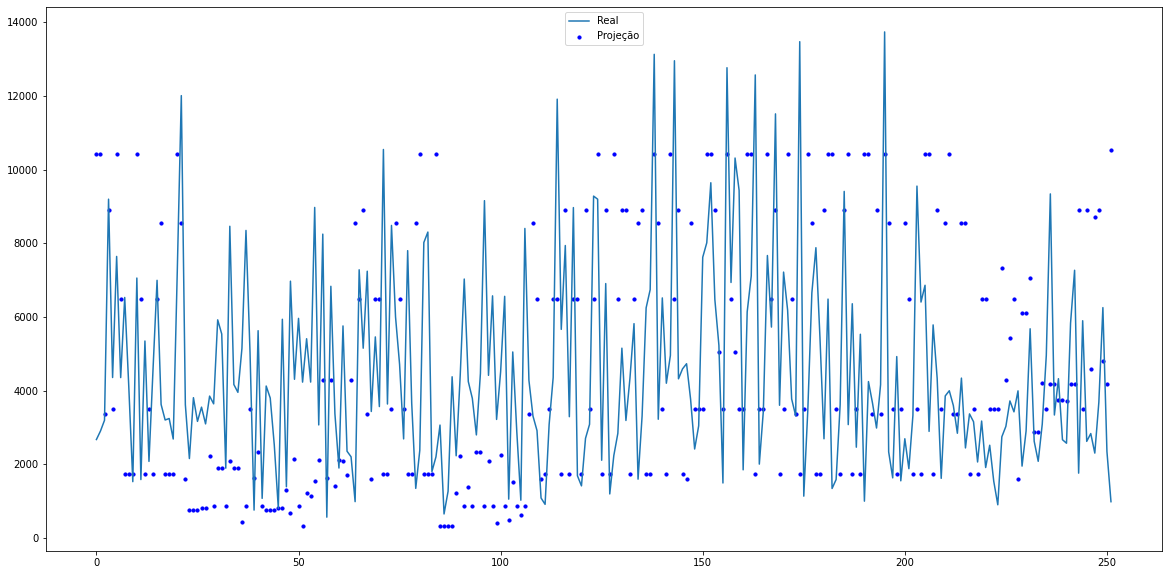

In [49]:
# Print dos resultados previstos em relação aos resultados reais

min_index = 0
max_index = 500

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df_20.index[min_index:max_index], y_teste_20[min_index:max_index], label='Real')
ax1.scatter(x_teste_df_20.index[min_index:max_index], pred_20[min_index:max_index], s=10, c='b', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [50]:
# Tabela com os dados reais, previstos e as diferenças entre eles

analise_20_arv = pd.DataFrame(pred_20,columns = ['y_pred'])
analise_20_arv['y_real'] = y_teste_20
analise_20_arv['dif_abs'] = ((analise_20_arv['y_pred'] - analise_20_arv['y_real'])**2)**(1/2)
analise_20_arv['dif_perc'] = 100*((analise_20_arv['y_pred'] - analise_20_arv['y_real'])**2)**(1/2)/(analise_20_arv['y_real'])
analise_20_arv.head()

,y_pred,y_real,dif_abs,dif_perc
0,10426.0,2677.00002,7748.99998,289.465817
1,10426.0,2907.00002,7518.99998,258.651528
2,3377.0,3199.00002,177.99998,5.564238
3,8901.0,9196.00002,295.00002,3.207917
4,3513.0,4359.00002,846.00002,19.408121


#  Árvore de decisão para o Dataframe de 40 TEUS

In [51]:
# Aplicação do modelo e vizualiação das métricas

print ('Decision Tree')

clf_40 = DecisionTreeRegressor()
clf_40.fit(x_treino_df_40, y_treino_40)
pred_40 = clf_40.predict(x_teste_df_40)
score_teste_40 = clf_40.score(x_teste_df_40, y_teste_40)
score_treino_40= clf_40.score(x_treino_df_40, y_treino_40)
print('40 TEU')
print("R-squared_treino:", score_treino_40) 
print("R-squared_teste:", score_teste_40) 
mse = mean_squared_error(y_teste_40, pred_40)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0)) 
print('Média de erro: ',med(y_teste_40,pred_40))

Decision Tree
40 TEU
R-squared_treino: 1.0
R-squared_teste: -1.0443550062318927
MSE:  17880962.524096426
RMSE:  4228.588715410429
Média de erro:  0.5524381271206837


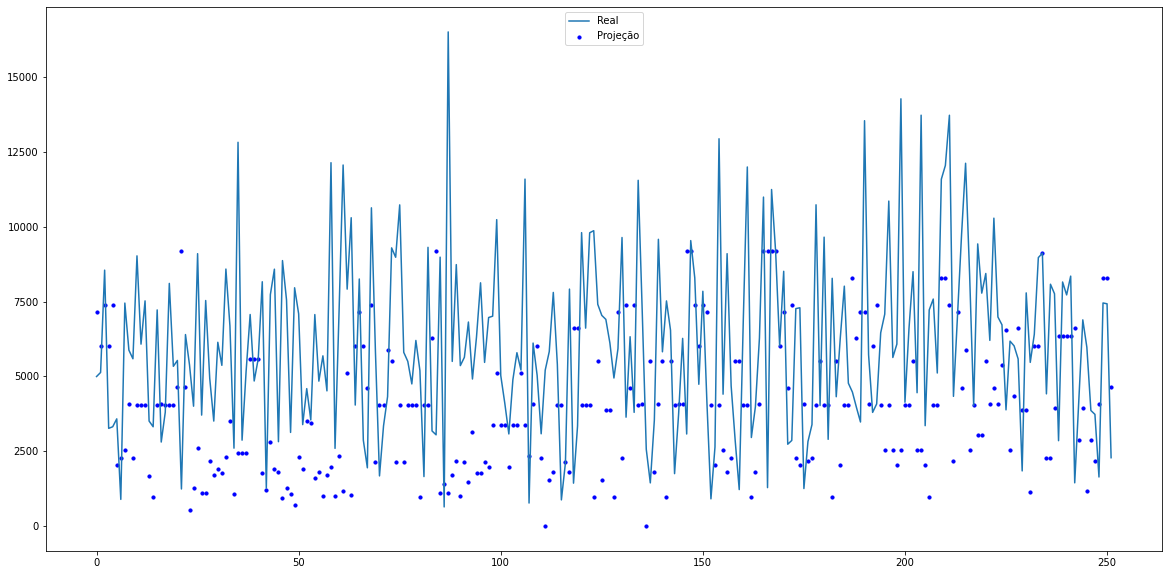

In [52]:
# Print dos resultados previstos em relação aos resultados reais

min_index = 0
max_index = 500

fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(111)

ax1.plot(x_teste_df_40.index[min_index:max_index], y_teste_40[min_index:max_index], label='Real')
ax1.scatter(x_teste_df_40.index[min_index:max_index], pred_40[min_index:max_index], s=10, c='b', marker="o", \
            label='Projeção')
plt.legend(loc='upper center')
plt.show()

In [53]:
# Tabela com os dados reais, previstos e as diferenças entre eles

analise_40_arv = pd.DataFrame(pred_40,columns = ['y_pred'])
analise_40_arv['y_real'] = y_teste_40
analise_40_arv['dif_abs'] = ((analise_40_arv['y_pred'] - analise_40_arv['y_real'])**2)**(1/2)
analise_40_arv['dif_perc'] = 100*((analise_40_arv['y_pred'] - analise_40_arv['y_real'])**2)**(1/2)/(analise_40_arv['y_real'])
analise_40_arv.head()

,y_pred,y_real,dif_abs,dif_perc
0,7138.0,4998.00002,2139.99998,42.817126
1,6026.0,5134.00002,891.99998,17.374367
2,7392.0,8552.00002,1160.00002,13.564079
3,6026.0,3267.00002,2758.99998,84.450565
4,7392.0,3321.00002,4070.99998,122.583558
